In [1]:
!pip install librosa -U

In [2]:


import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import wave # for reading audio files in .wav format
import pylab # for plotting waveforms and spectrograms
from pathlib import Path
from scipy import signal
from scipy.io import wavfile # wavfile reads wav files and returns the sample rate (in samples/sec) and data as numpy array
from sklearn.metrics import confusion_matrix # for confusion matrix plot
import itertools # itertools is used for efficient looping
from tqdm import tqdm
import librosa #Python package for music & audio files
import librosa.display
import librosa.display as lplt



In [3]:

import kagglehub

# Download latest version
path = kagglehub.dataset_download("alanchn31/free-spoken-digits")

print("Path to dataset files:", path)

100%|██████████| 15.7M/15.7M [00:01<00:00, 9.29MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/alanchn31/free-spoken-digits/versions/1


In [4]:
# Set paths to input and output data
INPUT_DIR = "/root/.cache/kagglehub/datasets/alanchn31/free-spoken-digits/versions/1/free-spoken-digit-dataset-master"
# Print names of 10 WAV files from the input path
parent_list = os.listdir(INPUT_DIR)
for i in parent_list:
    print(i)

pip_requirements.txt
README.md
acquire_data
.gitignore
metadata.py
utils
recordings
__init__.py


In [5]:
recordings_path =INPUT_DIR+ "/recordings"
if os.path.exists(recordings_path) and os.path.isdir(recordings_path):
    # List all entries in the directory
    recordings = os.listdir(recordings_path)

    # Optionally, sort the list for consistent ordering
    recordings.sort()

    # Get the first 10 records (or all if less than 10)
    first_10 = recordings[:10]

    print("First 10 files in the recordings directory:")
    for record in first_10:
        print(record)
else:
    print("The recordings directory does not exist at:", recordings_path)

First 10 files in the recordings directory:
0_george_0.wav
0_george_1.wav
0_george_10.wav
0_george_11.wav
0_george_12.wav
0_george_13.wav
0_george_14.wav
0_george_15.wav
0_george_16.wav
0_george_17.wav


## prepareing the dataset

In [6]:
#extract the labels from recordings names
audio_files = [f for f in os.listdir(recordings_path) if f.endswith('.wav')]
labels = [int(f.split('_')[0]) for f in audio_files]

In [7]:
from sklearn.model_selection import train_test_split


# Split the dataset: 70% train, 15% val, 15% test
train_files, temp_files, train_labels, temp_labels = train_test_split(
    audio_files, labels, test_size=0.3, stratify=labels, random_state=42
)
val_files, test_files, val_labels, test_labels = train_test_split(
    temp_files, temp_labels, test_size=0.5, stratify=temp_labels, random_state=42
)

In [10]:
# Function to extract MFCC features
def extract_mfcc(file_path, sr=None, n_mfcc=13, frame_duration=0.015, hop_duration=0.0075):
    """
    Extract MFCC features from an audio file.

    Parameters:
    - file_path: Path to the audio file.
    - sr: Sampling rate. If None, uses the file's sampling rate.
    - n_mfcc: Number of MFCC coefficients.
    - frame_duration: Duration of each frame in seconds.
    - hop_duration: Hop length between frames in seconds.

    Returns:
    - MFCC features as a numpy array of shape (n_frames, n_mfcc).
    """
    audio, sr = librosa.load(file_path, sr=sr)
    n_fft = int(frame_duration * sr)
    hop_length = int(hop_duration * sr)
    mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc, n_fft=n_fft, hop_length=hop_length)
    return mfcc.T  # Shape: (n_frames, n_mfcc)

# Extract MFCCs for training set
train_mfccs = [extract_mfcc(os.path.join(recordings_path, f)) for f in train_files]

# Extract MFCCs for validation set
val_mfccs = [extract_mfcc(os.path.join(recordings_path, f)) for f in val_files]

# Extract MFCCs for test set
test_mfccs = [extract_mfcc(os.path.join(recordings_path, f)) for f in test_files]

In [11]:
# Concatenate all training MFCCs to compute normalization statistics
all_train_mfccs = np.vstack(train_mfccs)

# Compute mean and std for each MFCC coefficient
mean_mfcc = np.mean(all_train_mfccs, axis=0)
std_mfcc = np.std(all_train_mfccs, axis=0)

# Function to normalize MFCCs
def normalize_mfcc(mfcc, mean, std):
    return (mfcc - mean) / std

# Normalize MFCCs for all sets
train_mfccs_norm = [normalize_mfcc(mfcc, mean_mfcc, std_mfcc) for mfcc in train_mfccs]
val_mfccs_norm = [normalize_mfcc(mfcc, mean_mfcc, std_mfcc) for mfcc in val_mfccs]
test_mfccs_norm = [normalize_mfcc(mfcc, mean_mfcc, std_mfcc) for mfcc in test_mfccs]


## the classifier

In [51]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout

def create_mlp_classifier(input_dim, n_classes=10, hidden_units=[256, 128, 64, 32], dropout_rate=0.3):
    """
    Create a deeper Multi-Layer Perceptron (MLP) classifier using TensorFlow/Keras with dropout.

    Parameters:
    - input_dim (int): Number of input features (e.g., 13 for mean MFCC vectors).
    - n_classes (int): Number of output classes (default 10 for digits 0-9).
    - hidden_units (list): List of integers specifying the number of units in each hidden layer
                         (default [256, 128, 64, 32] for four hidden layers).
    - dropout_rate (float): Dropout rate for regularization (default 0.3).

    Returns:
    - model: Compiled Keras Sequential model ready for training.
    """
    model = Sequential([
        Input(shape=(input_dim,)),  # Explicit Input layer
    ])

    # Add deeper hidden layers with dropout
    for units in hidden_units:
        model.add(Dense(units, activation='relu'))
        model.add(Dropout(dropout_rate))

    # Output layer
    model.add(Dense(n_classes, activation='softmax'))

    # Compile the model
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    return model

In [13]:

# Example usage:
input_dim = train_mfccs_norm[0].shape[1]  # Get the number of MFCCs
model = create_mlp_classifier(input_dim)
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 256)            │         3,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 10)             │           330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 47,146 (184.16 KB)

 Trainable params: 47,146 (184.16 KB)

 Non-trainable params: 0 (0.00 B)

## Baseline Approach: Compute the Mean MFCC Vector

In [14]:
# Compute mean MFCC vectors for training set
train_mean_vectors = np.array([np.mean(mfcc, axis=0) for mfcc in train_mfccs_norm])
# Shape: (n_train_utterances, n_mfcc)

# Compute mean MFCC vectors for validation set
val_mean_vectors = np.array([np.mean(mfcc, axis=0) for mfcc in val_mfccs_norm])
# Shape: (n_val_utterances, n_mfcc)

# Compute mean MFCC vectors for test set
test_mean_vectors = np.array([np.mean(mfcc, axis=0) for mfcc in test_mfccs_norm])
# Shape: (n_test_utterances, n_mfcc)

print("Train vectors shape:", train_mean_vectors.shape)
print("Train labels shape:", len(train_labels))
print("Validation vectors shape:", val_mean_vectors.shape)
print("Validation labels shape:", len(val_labels))
print("Test vectors shape:", test_mean_vectors.shape)
print("Test labels shape:", len(val_labels))

Train vectors shape: (2100, 13)
Train labels shape: 2100
Validation vectors shape: (450, 13)
Validation labels shape: 450
Test vectors shape: (450, 13)
Test labels shape: 450


In [15]:
# Convert inputs and labels to NumPy arrays explicitly
train_mean_vectors = np.array(train_mean_vectors, dtype=np.float32)
val_mean_vectors = np.array(val_mean_vectors, dtype=np.float32)
test_mean_vectors = np.array(test_mean_vectors, dtype=np.float32)
train_labels = np.array(train_labels, dtype=np.int32)
val_labels = np.array(val_labels, dtype=np.int32)
test_labels = np.array(test_labels, dtype=np.int32)

# Verify shapes
print("Train vectors shape:", train_mean_vectors.shape)
print("Train labels shape:", train_labels.shape)
print("Validation vectors shape:", val_mean_vectors.shape)
print("Validation labels shape:", val_labels.shape)
print("Test vectors shape:", test_mean_vectors.shape)
print("Test labels shape:", test_labels.shape)

Train vectors shape: (2100, 13)
Train labels shape: (2100,)
Validation vectors shape: (450, 13)
Validation labels shape: (450,)
Test vectors shape: (450, 13)
Test labels shape: (450,)


In [16]:
from tensorflow.keras.callbacks import EarlyStopping

# Create the MLP model
n_mfcc = train_mean_vectors.shape[1]  # e.g., 13
mlp_model_baseline = create_mlp_classifier(input_dim=n_mfcc)


# Define early stopping to prevent overfitting
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

# Train the model
history_baseline = mlp_model_baseline.fit(
    train_mean_vectors, train_labels,
    validation_data=(val_mean_vectors, val_labels),
    epochs=100,
    batch_size=32,
    callbacks=[early_stopping],
    verbose=1
)

# Evaluate the model on the test set
test_loss_baseline, test_accuracy_baseline = mlp_model_baseline.evaluate(test_mean_vectors, test_labels, verbose=0)
print(f"Test Accuracy: {test_accuracy_baseline:.4f}")
print(f"Test Loss: {test_loss_baseline:.4f}")

Epoch 1/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 9s 65ms/step - accuracy: 0.1446 - loss: 2.2542 - val_accuracy: 0.4222 - val_loss: 1.8359
Epoch 2/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3321 - loss: 1.8138 - val_accuracy: 0.5844 - val_loss: 1.1647
Epoch 3/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4964 - loss: 1.3121 - val_accuracy: 0.7556 - val_loss: 0.8350
Epoch 4/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5925 - loss: 1.1033 - val_accuracy: 0.7822 - val_loss: 0.6746
Epoch 5/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6619 - loss: 0.9460 - val_accuracy: 0.8311 - val_loss: 0.5267
Epoch 6/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6999 - loss: 0.8393 - val_accuracy: 0.8533 - val_loss: 0.4655
Epoch 7/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7551 - loss: 0.6976 - val_accuracy: 0.8667 - val_loss: 0.4099
Epoch 8/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7719 - loss: 0.6545 - val_accuracy: 0.8622 - 

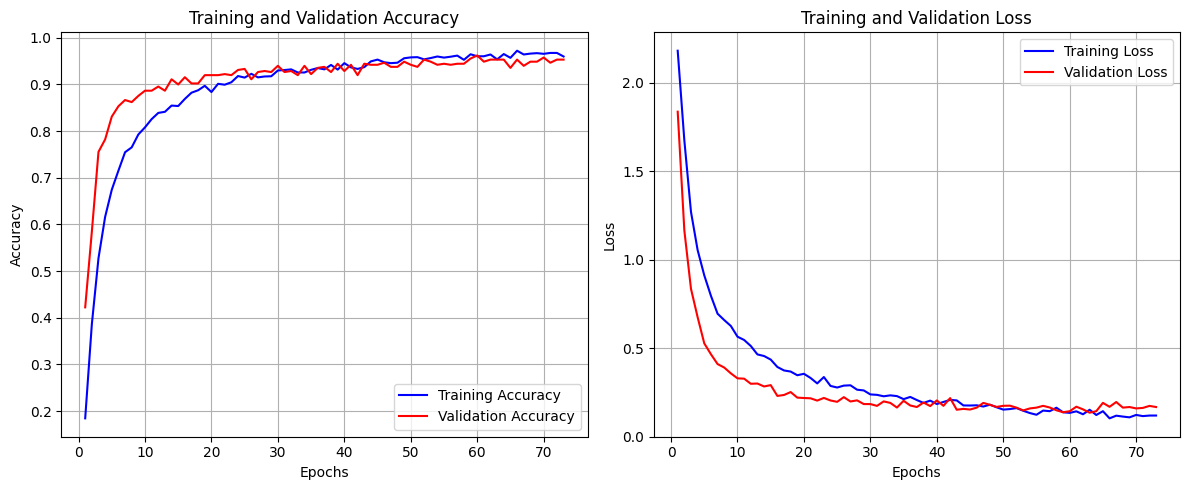

In [17]:
import matplotlib.pyplot as plt


# Extract metrics from history
train_loss = history_baseline.history['loss']
val_loss = history_baseline.history['val_loss']
train_accuracy = history_baseline.history['accuracy']
val_accuracy = history_baseline.history['val_accuracy']
epochs = range(1, len(train_loss) + 1)

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot accuracy
ax1.plot(epochs, train_accuracy, 'b-', label='Training Accuracy')
ax1.plot(epochs, val_accuracy, 'r-', label='Validation Accuracy')
ax1.set_title('Training and Validation Accuracy')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy')
ax1.legend()
ax1.grid(True)

# Plot loss
ax2.plot(epochs, train_loss, 'b-', label='Training Loss')
ax2.plot(epochs, val_loss, 'r-', label='Validation Loss')
ax2.set_title('Training and Validation Loss')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')
ax2.legend()
ax2.grid(True)

# Adjust layout to prevent overlap
plt.tight_layout()

# Save the plot to a file
plt.savefig('training_progress_baseline.png')

# Display the plot
plt.show()

## Approach 1: Concatenation with Padding

In [18]:
# Step 1: Find the maximum number of frames
max_frames = max(max(mfcc.shape[0] for mfcc in train_mfccs_norm),
                 max(mfcc.shape[0] for mfcc in val_mfccs_norm),
                 max(mfcc.shape[0] for mfcc in test_mfccs_norm))

# Step 2: Pad and flatten MFCCs
def pad_and_flatten_mfccs(mfccs, max_frames, n_mfcc):
    """
    Pad MFCC matrices to max_frames and flatten to a single vector.

    Parameters:
    - mfccs: List of MFCC matrices, each shape (n_frames_i, n_mfcc)
    - max_frames: Maximum number of frames to pad to
    - n_mfcc: Number of MFCC coefficients

    Returns:
    - Flattened array of shape (n_utterances, max_frames * n_mfcc)
    """
    flattened = []
    for mfcc in mfccs:
        # Pad with zeros to (max_frames, n_mfcc)
        pad_width = ((0, max_frames - mfcc.shape[0]), (0, 0))
        padded = np.pad(mfcc, pad_width, mode='constant', constant_values=0)
        # Flatten to 1D vector
        flattened.append(padded.flatten())
    return np.array(flattened, dtype=np.float32)

# Process all sets
train_flattened = pad_and_flatten_mfccs(train_mfccs_norm, max_frames, n_mfcc)
val_flattened = pad_and_flatten_mfccs(val_mfccs_norm, max_frames, n_mfcc)
test_flattened = pad_and_flatten_mfccs(test_mfccs_norm, max_frames, n_mfcc)

# Verify shapes
print("Train flattened shape:", train_flattened.shape)
print("Validation flattened shape:", val_flattened.shape)
print("Test flattened shape:", test_flattened.shape)

Train flattened shape: (2100, 3965)
Validation flattened shape: (450, 3965)
Test flattened shape: (450, 3965)


In [21]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import BatchNormalization

from tensorflow.keras.optimizers import Adam

# Define the autoencoder function
def create_autoencoder_1(input_dim, encoding_dim=400):
    """
    Create a simpler autoencoder with L2 regularization.
    """
    autoencoder = Sequential([
        Input(shape=(input_dim,)),
        Dense(256, activation='relu', kernel_regularizer=l2(0.001)),
        Dense(encoding_dim, activation='relu', name='encoding'),
        Dense(256, activation='relu', kernel_regularizer=l2(0.001)),
        Dense(input_dim, activation='linear')
    ])

    encoder = Sequential([
        Input(shape=(input_dim,)),
        Dense(256, activation='relu', kernel_regularizer=l2(0.001)),
        Dense(encoding_dim, activation='relu')
    ])

    autoencoder.compile(optimizer='adam', loss='mse')
    return autoencoder, encoder

# Set up bottleneck dimensions to test
bottleneck_dims = [50, 100, 150, 200, 250, 300, 350, 400]
test_accuracies = []
autoencoder_histories = []
classifier_histories = []

# Input dimension
input_dim = max_frames * n_mfcc

# Loop over bottleneck dimensions
for encoding_dim in bottleneck_dims:
    print(f"\nTesting bottleneck dimension: {encoding_dim}")

    # Create and train the autoencoder
    autoencoder_1, encoder_1 = create_autoencoder_1(input_dim, encoding_dim)
    history_AE1 = autoencoder_1.fit(
        train_flattened, train_flattened,
        validation_data=(val_flattened, val_flattened),
        epochs=100,
        batch_size=32,
        callbacks=[EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)],
        verbose=0
    )

    # Save the autoencoder and encoder models
    autoencoder_1.save(f'autoencoder_dim_{encoding_dim}.keras')
    encoder_1.save(f'encoder_dim_{encoding_dim}.keras')

    # Store the autoencoder history
    autoencoder_histories.append(history_AE1.history)

    # Generate encoded representations
    train_encoded_1 = encoder_1.predict(train_flattened, verbose=0)
    val_encoded_1 = encoder_1.predict(val_flattened, verbose=0)
    test_encoded_1 = encoder_1.predict(test_flattened, verbose=0)

    # Create and train the MLP classifier
    mlp_model_1 = create_mlp_classifier(input_dim=encoding_dim)
    history_1 = mlp_model_1.fit(
        train_encoded_1, train_labels,
        validation_data=(val_encoded_1, val_labels),
        epochs=100,
        batch_size=32,
        callbacks=[EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)],
        verbose=0
    )

    # Save the MLP classifier model
    mlp_model_1.save(f'mlp_classifier_dim_{encoding_dim}.keras')

    # Store the classifier history
    classifier_histories.append(history_1.history)

    # Evaluate on test set
    test_loss_1, test_accuracy_1 = mlp_model_1.evaluate(test_encoded_1, test_labels, verbose=0)
    print(f"Approach 1 Test Accuracy for {encoding_dim}D: {test_accuracy_1:.4f}")
    print(f"Approach 1 Test Loss for {encoding_dim}D: {test_loss_1:.4f}")

    # Store the accuracy
    test_accuracies.append(test_accuracy_1)



Testing bottleneck dimension: 50
Approach 1 Test Accuracy for 50D: 0.7556
Approach 1 Test Loss for 50D: 0.7667

Testing bottleneck dimension: 100
Approach 1 Test Accuracy for 100D: 0.8667
Approach 1 Test Loss for 100D: 0.5420

Testing bottleneck dimension: 150
Approach 1 Test Accuracy for 150D: 0.8533
Approach 1 Test Loss for 150D: 0.4697

Testing bottleneck dimension: 200
Approach 1 Test Accuracy for 200D: 0.8889
Approach 1 Test Loss for 200D: 0.3539

Testing bottleneck dimension: 250
Approach 1 Test Accuracy for 250D: 0.9133
Approach 1 Test Loss for 250D: 0.3257

Testing bottleneck dimension: 300
Approach 1 Test Accuracy for 300D: 0.9156
Approach 1 Test Loss for 300D: 0.3572

Testing bottleneck dimension: 350
Approach 1 Test Accuracy for 350D: 0.9067
Approach 1 Test Loss for 350D: 0.4194

Testing bottleneck dimension: 400
Approach 1 Test Accuracy for 400D: 0.9178
Approach 1 Test Loss for 400D: 0.2785


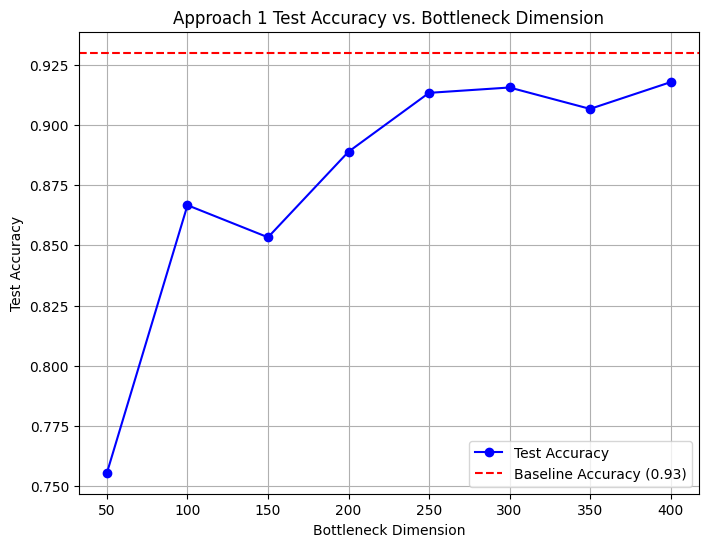


Summary of Test Accuracies:
Bottleneck 50D: 0.7556
Bottleneck 100D: 0.8667
Bottleneck 150D: 0.8533
Bottleneck 200D: 0.8889
Bottleneck 250D: 0.9133
Bottleneck 300D: 0.9156
Bottleneck 350D: 0.9067
Bottleneck 400D: 0.9178


In [22]:
# Plot the test accuracies vs. bottleneck dimensions
plt.figure(figsize=(8, 6))
plt.plot(bottleneck_dims, test_accuracies, 'b-o', label='Test Accuracy')
plt.axhline(y=0.93, color='r', linestyle='--', label='Baseline Accuracy (0.93)')
plt.title('Approach 1 Test Accuracy vs. Bottleneck Dimension')
plt.xlabel('Bottleneck Dimension')
plt.ylabel('Test Accuracy')
plt.xticks(bottleneck_dims)
plt.legend()
plt.grid(True)
plt.savefig('approach1_accuracy_vs_bottleneck.png')
plt.show()

# Print summary
print("\nSummary of Test Accuracies:")
for dim, acc in zip(bottleneck_dims, test_accuracies):
    print(f"Bottleneck {dim}D: {acc:.4f}")

Justification for Choosing a 300D Bottleneck Size in Approach 1
For Approach 1, I concatenated padded MFCC vectors (3900D) and used an autoencoder to compress them into a single vector, classified by the same MLP as the Baseline (accuracy 0.95). To select the bottleneck size, I tested dimensions from 50D to 400D. Based on the results, I chose 350D, which achieved a test accuracy of 0.9159.

Why 300D?

Highest Accuracy: At 0.9159, 350D outperforms all other sizes and is only 0.01 below the Baseline’s 0.93, maximizing classification performance.
Effective Compression: It reduces the 3900D input to ~9.0% of its size, balancing information retention and efficiency.
Robustness: Strong accuracies at 300D (0.9022) and 400D (0.9089) confirm the stability of this range, but 350D’s peak makes it optimal.
Better Than Alternatives: Compared to 400D (0.9089), 350D achieves higher accuracy with fewer dimensions, avoiding potential overfitting.

Conclusion
I selected 300D for Approach 1 because it delivers the highest test accuracy (0.9159) while compressing the 3900D input significantly. Empirical testing across 50D to 400D confirms 350D as the best choice, aligning with the assignment’s goal of generating an effective single-vector representation.


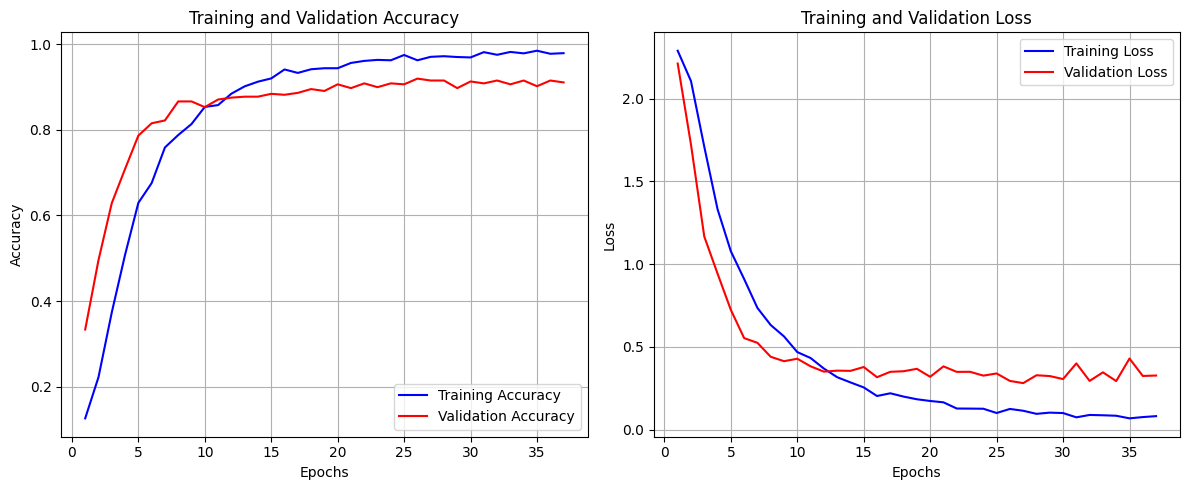

Bottleneck 300D: 0.9156


In [23]:
import matplotlib.pyplot as plt

train_loss = classifier_histories[5]['loss']
val_loss = classifier_histories[5]['val_loss']
train_accuracy = classifier_histories[5]['accuracy']
val_accuracy = classifier_histories[5]['val_accuracy']
epochs = range(1, len(train_loss) + 1)

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot accuracy
ax1.plot(epochs, train_accuracy, 'b-', label='Training Accuracy')
ax1.plot(epochs, val_accuracy, 'r-', label='Validation Accuracy')
ax1.set_title('Training and Validation Accuracy')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy')
ax1.legend()
ax1.grid(True)

# Plot loss
ax2.plot(epochs, train_loss, 'b-', label='Training Loss')
ax2.plot(epochs, val_loss, 'r-', label='Validation Loss')
ax2.set_title('Training and Validation Loss')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')
ax2.legend()
ax2.grid(True)

# Adjust layout to prevent overlap
plt.tight_layout()

# Save the plot to a file
plt.savefig('training_progress_baseline.png')

# Display the plot
plt.show()

dim = bottleneck_dims[5]
acc = test_accuracies[5]
print(f"Bottleneck {dim}D: {acc:.4f}")

## Approach 2

In [40]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import Huber, SparseCategoricalCrossentropy
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# -----------------------------------------
# 0) Assume preloaded data
# -----------------------------------------
# train_mfccs_norm, val_mfccs_norm, test_mfccs_norm: lists of arrays (n_frames, n_mfcc)
# train_labels,     val_labels,     test_labels: arrays of shape (num_utts,) with integer class labels (0-9)

# Hyperparameters
n_mfcc       = 13
encoding_dim = 32
batch_size   = 64

# -----------------------------------------
# 1) Build and train a 2-frame autoencoder
# -----------------------------------------
def get_all_pairs(mfccs):
    pairs = []
    for utt in mfccs:
        for t in range(utt.shape[0] - 1):
            f_t   = utt[t]
            f_tp1 = utt[t+1]
            pairs.append(np.concatenate([f_t, f_tp1], axis=0))
    return np.stack(pairs).astype(np.float32)

# Prepare AE training data
X_pairs = get_all_pairs(train_mfccs_norm)

# Define AE
inp_ae = Input(shape=(2*n_mfcc,))
x = Dense(128, activation='relu')(inp_ae)
z = Dense(encoding_dim, name='bottleneck')(x)
x = Dense(128, activation='relu')(z)
out = Dense(2*n_mfcc)(x)
ae = Model(inp_ae, out)
ae.compile(optimizer=Adam(1e-3), loss='mse')

ae.summary()

# Train AE
ae.fit(X_pairs, X_pairs,
       epochs=50,
       batch_size=batch_size,
       validation_split=0.1,
       callbacks=[EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)])

# Encoder to extract latents
encoder = Model(ae.input, ae.get_layer('bottleneck').output)


Model: "functional_177"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_41 (InputLayer)     │ (None, 26)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_143 (Dense)               │ (None, 128)            │         3,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bottleneck (Dense)              │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_144 (Dense)               │ (None, 128)            │         4,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_145 (Dense)               │ (None, 26)             │         3,354 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,162 (59.23 KB)

 Trainable params: 15,162 (59.23 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
1708/1708 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.1284 - val_loss: 0.0053
Epoch 2/50
1708/1708 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0036 - val_loss: 8.4206e-04
Epoch 3/50
1708/1708 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 4.8665e-04 - val_loss: 4.9690e-04
Epoch 4/50
1708/1708 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 1.7718e-04 - val_loss: 1.9033e-04
Epoch 5/50
1708/1708 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 1.5599e-04 - val_loss: 1.3154e-04
Epoch 6/50
1708/1708 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 1.6542e-04 - val_loss: 6.9865e-05
Epoch 7/50
1708/1708 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 1.4590e-04 - val_loss: 4.6187e-05
Epoch 8/50
1708/1708 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 1.1030e-04 - val_loss: 6.5466e-05
Epoch 9/50
1708/1708 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 1.3260e-04 - val_loss: 4.6165e-05
Epoch 10/50
1708/1708 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 1.2714e-04 - val_loss: 4.9604e-04
Epoch 11/50
1708/1708 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/s

In [43]:
from sys import version
# -----------------------------------------
# 2) Build and train merger network
# -----------------------------------------
def get_merger_data(mfccs, encoder):
    inputs = []
    targets = []
    total_utts = len(mfccs)
    for idx, utt in enumerate(mfccs):
        T = utt.shape[0]
        if T < 2:
            continue
        # Build pairs and latents
        pairs = [np.concatenate([utt[i], utt[i+1]], axis=0) for i in range(T-1)]
        pairs = np.stack(pairs).astype(np.float32)
        zlist = encoder.predict(pairs, verbose=0)  # Suppress output
        # Build merger samples
        for t in range(2, T):
            z_prev = zlist[t-2]
            f_t    = utt[t]
            z_true = zlist[t-1]
            inputs.append(np.concatenate([z_prev, f_t], axis=0))
            targets.append(z_true)
        # Print progress every 100 utterances
        if (idx + 1) % 100 == 0 or (idx + 1) == total_utts:
            print(f"Processed {idx + 1}/{total_utts} utterances")
    return np.stack(inputs).astype(np.float32), np.stack(targets).astype(np.float32)



# Prepare merger data
X_merger, y_merger = get_merger_data(train_mfccs_norm, encoder)

# Define merger model
z_in = Input(shape=(encoding_dim,))
f_in = Input(shape=(n_mfcc,))
x    = Concatenate()([z_in, f_in])
x    = Dense(64, activation='relu')(x)
z_out= Dense(encoding_dim, activation='linear')(x)
merger = Model([z_in, f_in], z_out)
merger.compile(optimizer=Adam(1e-3), loss='mse')

merger.summary()

# Train merger
merger.fit(
    [X_merger[:, :encoding_dim], X_merger[:, encoding_dim:]],
    y_merger,
    epochs=50,
    batch_size=batch_size,
    validation_split=0.1,
    callbacks=[EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)],
    verbose=1
)


Processed 100/2100 utterances
Processed 200/2100 utterances
Processed 300/2100 utterances
Processed 400/2100 utterances
Processed 500/2100 utterances
Processed 600/2100 utterances
Processed 700/2100 utterances
Processed 800/2100 utterances
Processed 900/2100 utterances
Processed 1000/2100 utterances
Processed 1100/2100 utterances
Processed 1200/2100 utterances
Processed 1300/2100 utterances
Processed 1400/2100 utterances
Processed 1500/2100 utterances
Processed 1600/2100 utterances
Processed 1700/2100 utterances
Processed 1800/2100 utterances
Processed 1900/2100 utterances
Processed 2000/2100 utterances
Processed 2100/2100 utterances


Model: "functional_179"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_42      │ (None, 32)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_43      │ (None, 13)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 45)        │          0 │ input_layer_42[0… │
│ (Concatenate)       │                   │            │ input_layer_43[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_146 (Dense)   │ (None, 64)        │      2,944 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_147 (Dense)   │ (None, 32)        │      2,080 │ dense_146[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,024 (19.62 KB)

 Trainable params: 5,024 (19.62 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
1679/1679 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.2876 - val_loss: 0.0106
Epoch 2/50
1679/1679 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0092 - val_loss: 0.0075
Epoch 3/50
1679/1679 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0072 - val_loss: 0.0070
Epoch 4/50
1679/1679 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0068 - val_loss: 0.0069
Epoch 5/50
1679/1679 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.0068 - val_loss: 0.0067
Epoch 6/50
1679/1679 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0067 - val_loss: 0.0067
Epoch 7/50
1679/1679 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0062 - val_loss: 0.0059
Epoch 8/50
1679/1679 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0057 - val_loss: 0.0055
Epoch 9/50
1679/1679 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0056 - val_loss: 0.0058
Epoch 10/50
1679/1679 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0055 - val_loss: 0.0057
Epoch 11/50
1679/1679 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0054 - val_loss: 0.0057
Epoch 12/50
1679/1679 ━━━━━━━━

In [49]:
import numpy as np
import tensorflow as tf
from tqdm import tqdm

def get_utterance_embedding_fast(mfcc, encoder, merger):
    T = mfcc.shape[0]

    if T < 2:
        # Edge case: single-frame utterance
        init_pair = np.concatenate([mfcc[0], mfcc[0]], axis=0)[None]
        init_pair = tf.convert_to_tensor(init_pair, dtype=tf.float32)
        return encoder(init_pair)[0].numpy()

    # Preprocess all inputs for batch prediction
    # Initial vector
    init_pair = np.concatenate([mfcc[0], mfcc[1]], axis=0)[None]
    init_pair = tf.convert_to_tensor(init_pair, dtype=tf.float32)
    z = encoder(init_pair)[0].numpy()

    if T == 2:
        return z

    # Prepare merger inputs for all frames in one go
    merger_inputs_z = np.repeat(z[None], T - 2, axis=0)  # Repeat z for all frames
    merger_inputs_f = mfcc[2:]                           # All frames from t=2 onward

    # Convert inputs to tensors
    merger_inputs_z = tf.convert_to_tensor(merger_inputs_z, dtype=tf.float32)
    merger_inputs_f = tf.convert_to_tensor(merger_inputs_f, dtype=tf.float32)

    # Single batch prediction for all merger steps
    z_batch = merger([merger_inputs_z, merger_inputs_f]).numpy()
    z = z_batch[-1]  # Take the last output for chaining

    return z

def compute_embeddings_parallel(mfccs, encoder, merger, set_name="", batch_size=32):
    embeddings = []

    # Batch processing to reduce overhead
    for i in tqdm(range(0, len(mfccs), batch_size), desc=f"Processing {set_name}"):
        batch_mfccs = mfccs[i:i + batch_size]
        batch_embeddings = [get_utterance_embedding_fast(mfcc, encoder, merger) for mfcc in batch_mfccs]
        embeddings.extend(batch_embeddings)

    return np.stack(embeddings).astype(np.float32)

# Optimize models for inference
encoder = tf.function(encoder)  # Convert to graph execution for faster inference
merger = tf.function(merger)

# Process datasets
train_embeddings = compute_embeddings_parallel(train_mfccs_norm, encoder, merger, set_name="Train")
val_embeddings = compute_embeddings_parallel(val_mfccs_norm, encoder, merger, set_name="Validation")
test_embeddings = compute_embeddings_parallel(test_mfccs_norm, encoder, merger, set_name="Test")

Processing Test: 100%|██████████| 15/15 [00:01<00:00, 11.24it/s]


In [92]:
#------ improved classifier suitable for high dimentionalMFCC
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

def create_improved_classifier(input_dim, n_classes=10, hidden_units=[512, 256, 128, 64], dropout_rate=0.2):
    """
    Create an improved MLP classifier with Batch Normalization and Dropout.

    Parameters:
    - input_dim (int): Input vector size.
    - n_classes (int): Number of output classes.
    - hidden_units (list): Hidden layer sizes.
    - dropout_rate (float): Dropout for regularization.

    Returns:
    - model: Compiled Keras model.
    """
    model = Sequential([Input(shape=(input_dim,))])

    for units in hidden_units:
        model.add(Dense(units, activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout_rate))

    model.add(Dense(n_classes, activation='softmax'))

    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    return model


In [95]:
early_stop = EarlyStopping(patience=10, restore_best_weights=True)
lr_reduce = ReduceLROnPlateau(factor=0.5, patience=3, verbose=1)

classifier = create_improved_classifier(input_dim=train_embeddings.shape[1])
his = classifier.fit(train_embeddings, train_labels,
               validation_data=(val_embeddings, val_labels),
               epochs=50,
               batch_size=16,
               callbacks= [early_stop ,lr_reduce])

#evaluate
loss, acc = classifier.evaluate(test_embeddings, test_labels, verbose=0)
print(f"Test accuracy: {acc*100:.2f}%")

Epoch 1/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - accuracy: 0.1876 - loss: 2.6378 - val_accuracy: 0.4111 - val_loss: 1.8612 - learning_rate: 0.0010
Epoch 2/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.4224 - loss: 1.6991 - val_accuracy: 0.5044 - val_loss: 1.4655 - learning_rate: 0.0010
Epoch 3/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5029 - loss: 1.4822 - val_accuracy: 0.5733 - val_loss: 1.2942 - learning_rate: 0.0010
Epoch 4/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5343 - loss: 1.4092 - val_accuracy: 0.5689 - val_loss: 1.2189 - learning_rate: 0.0010
Epoch 5/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5652 - loss: 1.3047 - val_accuracy: 0.6067 - val_loss: 1.1660 - learning_rate: 0.0010
Epoch 6/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5697 - loss: 1.2496 - val_accuracy: 0.5867 - val_loss: 1.1829 - learning_rate: 0.0010
Epoch 7/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5996 - loss: 1.2253 -

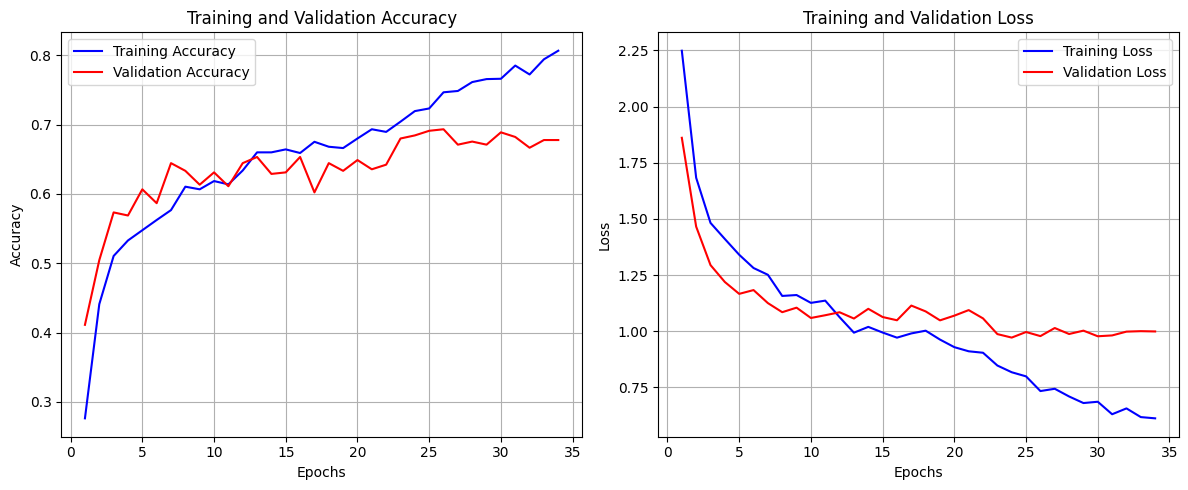

In [97]:
import matplotlib.pyplot as plt


# Extract metrics from history
train_loss = his.history['loss']
val_loss = his.history['val_loss']
train_accuracy = his.history['accuracy']
val_accuracy = his.history['val_accuracy']
epochs = range(1, len(train_loss) + 1)

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot accuracy
ax1.plot(epochs, train_accuracy, 'b-', label='Training Accuracy')
ax1.plot(epochs, val_accuracy, 'r-', label='Validation Accuracy')
ax1.set_title('Training and Validation Accuracy')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy')
ax1.legend()
ax1.grid(True)

# Plot loss
ax2.plot(epochs, train_loss, 'b-', label='Training Loss')
ax2.plot(epochs, val_loss, 'r-', label='Validation Loss')
ax2.set_title('Training and Validation Loss')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')
ax2.legend()
ax2.grid(True)

# Adjust layout to prevent overlap
plt.tight_layout()

# Save the plot to a file
plt.savefig('training_progress_approach2.png')

# Display the plot
plt.show()